In [1]:
# !pip install shap

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import shap
import re

In [3]:
# 데이터 불러오기 
df = pd.read_csv('./SCALE불량.csv', encoding='cp949')
df.head()

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group
0,PLT_1001,03JAN2023:07:07:53,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,1열,1144,116,1133,59,259,TMCP(온도제어),934,8,1조
1,PLT_1002,03JAN2023:07:21:22,양품,AB/EH32-TM,미국,T,32,3700,15100,적용,...,2열,1144,122,1135,53,238,TMCP(온도제어),937,8,1조
2,PLT_1003,03JAN2023:07:31:15,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,1열,1129,116,1121,55,258,TMCP(온도제어),889,8,1조
3,PLT_1004,03JAN2023:07:41:01,양품,NV-E36-TM,영국,T,33,3600,19200,적용,...,2열,1152,125,1127,68,266,TMCP(온도제어),885,8,1조
4,PLT_1005,03JAN2023:07:52:40,양품,BV-EH36-TM,프랑스,T,38,3100,13300,적용,...,1열,1140,134,1128,48,246,TMCP(온도제어),873,8,1조


In [4]:
# # pt_area 파생변수 생성
# df['pt_area'] = df['pt_length'] * df['pt_thick']

In [5]:
df.columns

Index(['plate_no', 'rolling_date', 'scale', 'spec_long', 'spec_country',
       'steel_kind', 'pt_thick', 'pt_width', 'pt_length', 'hsb', 'fur_no',
       'fur_input_row', 'fur_heat_temp', 'fur_heat_time', 'fur_soak_temp',
       'fur_soak_time', 'fur_total_time', 'rolling_method', 'rolling_temp',
       'descaling_count', 'work_group'],
      dtype='object')

In [6]:
# 데이터 전처리
# plate_no (문자열 제거)
df['plate_no'] = df['plate_no'].apply(lambda x: int(re.sub(r'\D', '', str(x))))

# scale (양품 = 0, 불량 = 1)
df['scale'] = df['scale'].map(lambda x : 0 if x == '양품' else 1) 
df['scale'].head()

# # steel_kind (T = 1, C = 2)
# df['steel_kind'] = df['steel_kind'].map({'T': 1, 'C': 2}).astype(int)

# rolling_method (TMCP = 1, CR = 2)
df['rolling_method'] = df['rolling_method'].apply(lambda x: re.sub(r'\W.*$', '', x)) 
df['rolling_method'] = df['rolling_method'].replace({'TMCP': 1, 'CR': 2}).astype(int)

# hsb (적용 = 1, 미적용 = 2)
df['hsb'] = df['hsb'].map({'적용': 1, '미적용': 2}).astype(int)

# 이상치 제거 (rolling_temp 값이 0인 데이터)
df = df[df['rolling_temp'] != 0]
# # 이상치 제거 (hsb 미적용 데이터)
# df = df[df['hsb'] != 2]

In [7]:
df.head()

,plate_no,rolling_date,scale,spec_long,spec_country,steel_kind,pt_thick,pt_width,pt_length,hsb,...,fur_input_row,fur_heat_temp,fur_heat_time,fur_soak_temp,fur_soak_time,fur_total_time,rolling_method,rolling_temp,descaling_count,work_group
0,1001,03JAN2023:07:07:53,0,AB/EH32-TM,미국,T,32,3700,15100,1,...,1열,1144,116,1133,59,259,1,934,8,1조
1,1002,03JAN2023:07:21:22,0,AB/EH32-TM,미국,T,32,3700,15100,1,...,2열,1144,122,1135,53,238,1,937,8,1조
2,1003,03JAN2023:07:31:15,0,NV-E36-TM,영국,T,33,3600,19200,1,...,1열,1129,116,1121,55,258,1,889,8,1조
3,1004,03JAN2023:07:41:01,0,NV-E36-TM,영국,T,33,3600,19200,1,...,2열,1152,125,1127,68,266,1,885,8,1조
4,1005,03JAN2023:07:52:40,0,BV-EH36-TM,프랑스,T,38,3100,13300,1,...,1열,1140,134,1128,48,246,1,873,8,1조


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 994 entries, 0 to 999
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   plate_no         994 non-null    int64 
 1   rolling_date     994 non-null    object
 2   scale            994 non-null    int64 
 3   spec_long        994 non-null    object
 4   spec_country     994 non-null    object
 5   steel_kind       994 non-null    object
 6   pt_thick         994 non-null    int64 
 7   pt_width         994 non-null    int64 
 8   pt_length        994 non-null    int64 
 9   hsb              994 non-null    int64 
 10  fur_no           994 non-null    object
 11  fur_input_row    994 non-null    object
 12  fur_heat_temp    994 non-null    int64 
 13  fur_heat_time    994 non-null    int64 
 14  fur_soak_temp    994 non-null    int64 
 15  fur_soak_time    994 non-null    int64 
 16  fur_total_time   994 non-null    int64 
 17  rolling_method   994 non-null    in

In [9]:
# # 특성 엔지니어링 - 파생 변수 생성
# df['is_even_descaling'] = df['descaling_count'] % 2 == 0
# df['high_fur_heat_temp'] = df['fur_heat_temp'] > 1200
# df['high_fur_soak_temp'] = df['fur_soak_temp'] > 1175
# df['high_rolling_temp'] = df['rolling_temp'] > 1000
# df['hsb_unapplied'] = df['hsb'] == 2

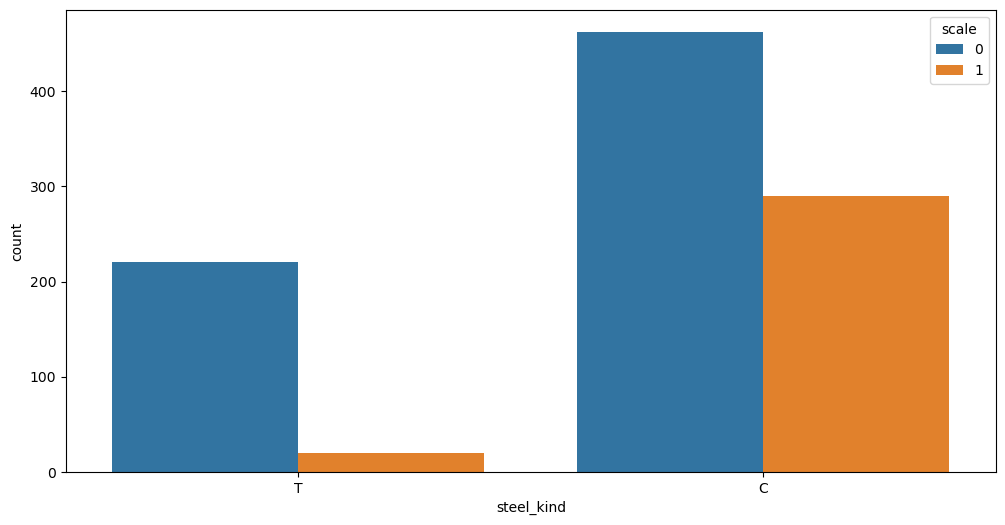

In [10]:
df['steel_kind'].value_counts()

# 시각화 
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='steel_kind', hue='scale')
plt.show()

In [11]:
# Split the dataset based on 'steel_kind'
df_T = df[df['steel_kind'] == 'T'] 
df_C = df[df['steel_kind'] == 'C']

In [12]:
# T 타입에 대한 변수 선택
df_T = df_T[['pt_thick', 'hsb', 'fur_heat_temp', 'fur_heat_time', 'fur_soak_temp', 'rolling_temp', 'rolling_method', 'descaling_count', 'scale']]

# C 타입에 대한 변수 선택
df_C = df_C[['pt_thick', 'hsb', 'fur_heat_temp', 'fur_heat_time', 'fur_soak_temp', 'rolling_temp', 'rolling_method', 'descaling_count', 'scale']]

In [13]:
df_T

,pt_thick,hsb,fur_heat_temp,fur_heat_time,fur_soak_temp,rolling_temp,rolling_method,descaling_count,scale
0,32,1,1144,116,1133,934,1,8,0
1,32,1,1144,122,1135,937,1,8,0
2,33,1,1129,116,1121,889,1,8,0
3,33,1,1152,125,1127,885,1,8,0
4,38,1,1140,134,1128,873,1,8,0
...,...,...,...,...,...,...,...,...,...
618,77,1,1103,68,1122,848,1,6,0
619,74,1,1144,102,1123,814,2,6,0
620,76,1,1124,77,1127,811,2,6,0
621,76,2,1123,55,1135,811,2,6,1


In [14]:
df_C

,pt_thick,hsb,fur_heat_temp,fur_heat_time,fur_soak_temp,rolling_temp,rolling_method,descaling_count,scale
117,20,1,1129,76,1126,934,2,8,0
118,20,1,1140,68,1132,911,2,8,0
119,17,1,1130,71,1130,935,2,10,0
120,17,1,1130,71,1130,935,2,10,0
121,14,1,1140,80,1131,915,2,10,0
...,...,...,...,...,...,...,...,...,...
995,19,1,1142,55,1151,948,2,10,0
996,19,1,1142,55,1151,948,2,10,0
997,17,1,1169,65,1163,948,2,10,0
998,17,1,1169,65,1163,948,2,10,0


In [15]:
print(df_T.shape)
print(df_C.shape)

(241, 9)
(753, 9)


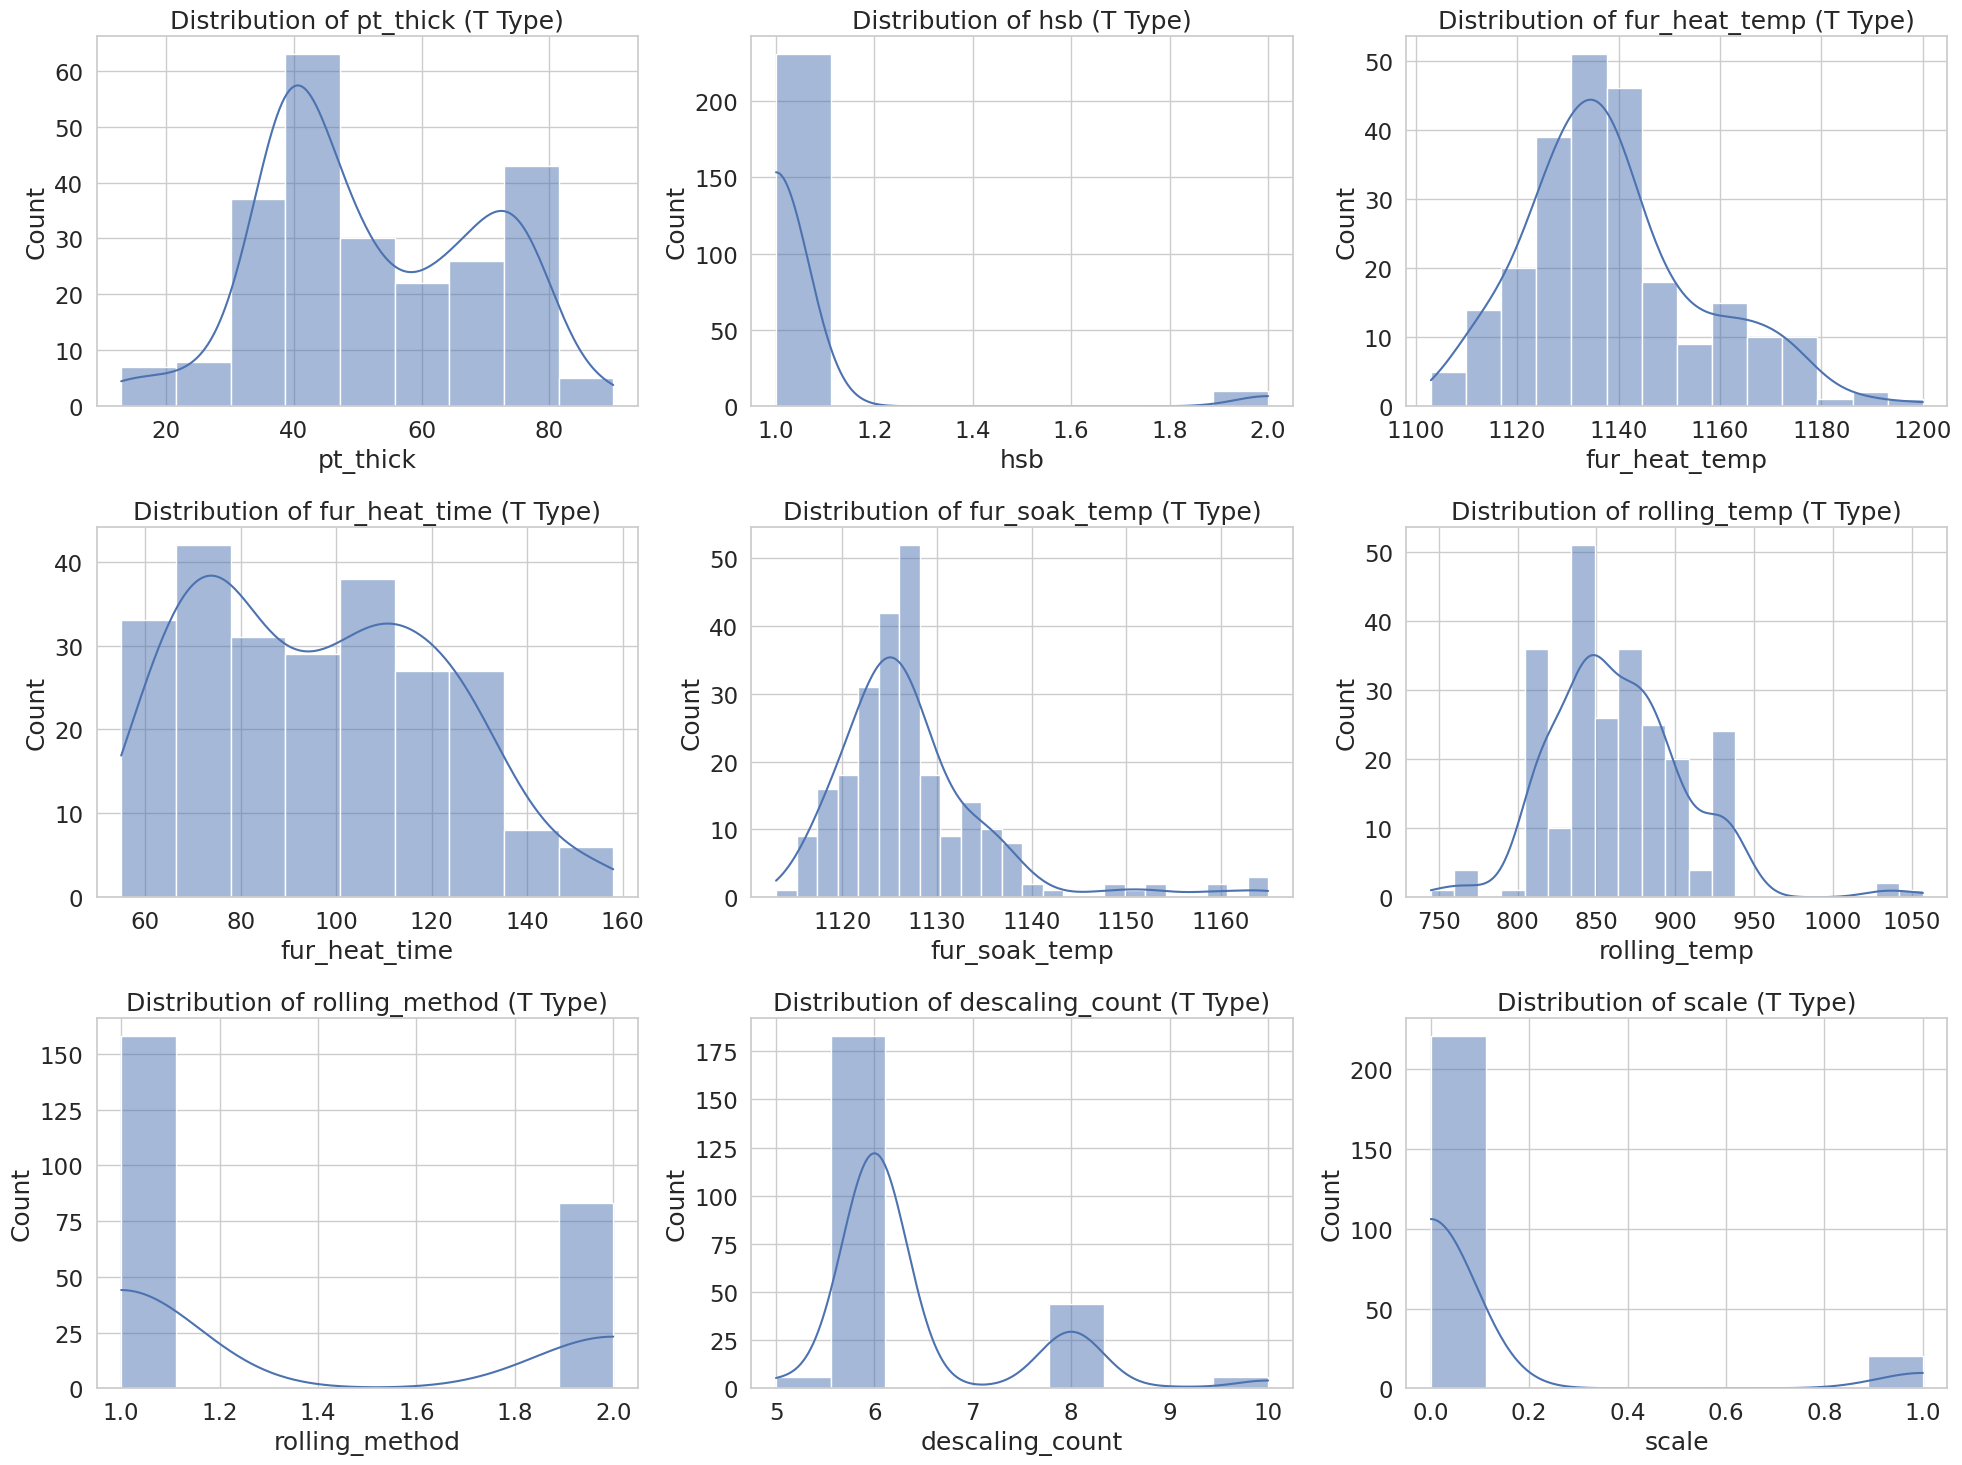

In [16]:
# T 타입에 대한 시각화할 변수 리스트
columns_T = ['pt_thick', 'hsb', 'fur_heat_temp', 'fur_heat_time', 'fur_soak_temp', 'rolling_temp', 'rolling_method', 'descaling_count', 'scale']

# 그래프 설정
plt.figure(figsize=(20, 15))  # 크기를 적절히 조정
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

# 변수별로 서브플롯에 그래프 그리기 (T 타입)
for i, column in enumerate(columns_T, 1):
    plt.subplot(3, 3, i)  # 3행 3열의 서브플롯
    sns.histplot(df_T[column], kde=True)  # 히스토그램 + KDE 커브
    plt.title(f'Distribution of {column} (T Type)')

plt.tight_layout()
plt.show()

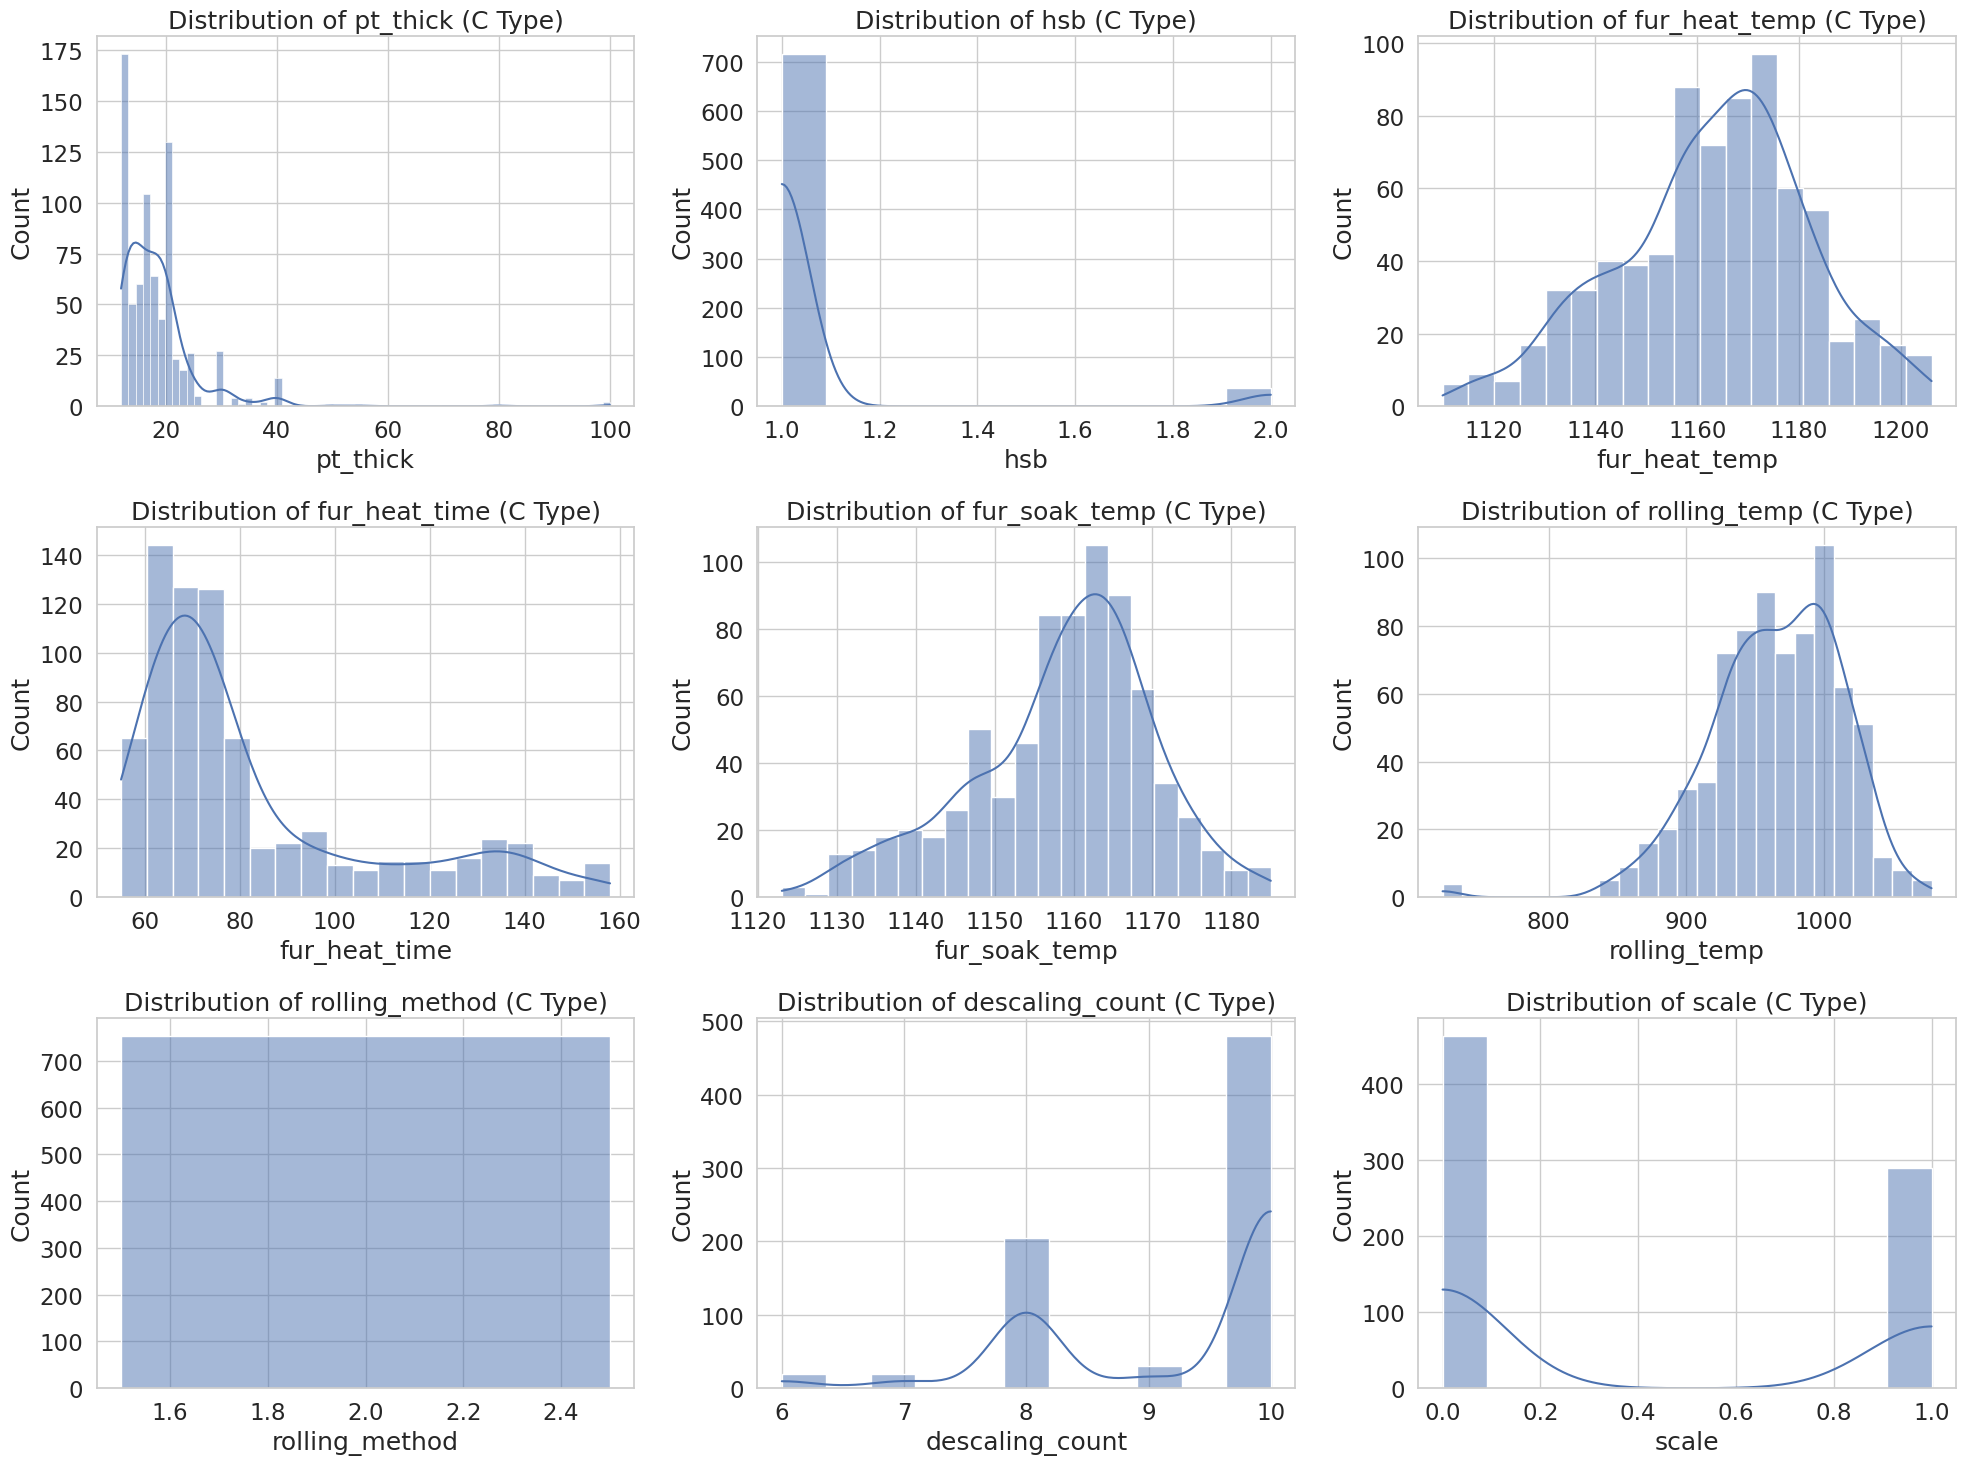

In [17]:
# C 타입에 대한 시각화할 변수 리스트
columns_C = ['pt_thick', 'hsb', 'fur_heat_temp', 'fur_heat_time', 'fur_soak_temp', 'rolling_temp', 'rolling_method', 'descaling_count', 'scale']

# 그래프 설정
plt.figure(figsize=(20, 15))  # 그래프 크기를 적절히 설정
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

# 변수별로 서브플롯에 그래프 그리기 (C 타입)
for i, column in enumerate(columns_C, 1):
    plt.subplot(3, 3, i)  # 3행 3열의 서브플롯
    sns.histplot(df_C[column], kde=True)  # 히스토그램 + KDE 커브
    plt.title(f'Distribution of {column} (C Type)')

plt.tight_layout()
plt.show()

### 2-4. 모델 학습 및 평가 

In [18]:
def train_and_evaluate_models(df, kind):
    print(f"--- Results for steel_kind = {kind} ---")
    
    # 입력 변수(X)와 목표 변수(y) 분리
    X = df.drop('scale', axis=1)
    y = df['scale']
    
    # 학습 데이터와 테스트 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)
    
    # 모델 리스트 (기본)
    models = {
        "Logistic Regression": LogisticRegression(random_state=1234),
        "Decision Tree": DecisionTreeClassifier(random_state=1234),
        "Random Forest": RandomForestClassifier(random_state=1234),
        "Gradient Boosting": GradientBoostingClassifier(random_state=1234),
        "XGBoost": xgb.XGBClassifier(random_state=1234, use_label_encoder=False, eval_metric='logloss')
    }
    
    # 모델 학습 및 평가
    results = []
    feature_importances = {}
    
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else 'N/A'
        
        results.append({
            "Model": model_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "ROC AUC": roc_auc
        })
        
        # 변수 중요도 저장 (트리 기반 모델)
        if model_name in ["Decision Tree", "Random Forest", "Gradient Boosting", "XGBoost"]:
            feature_importances[model_name] = model.feature_importances_
    
    # 결과 출력
    results_df = pd.DataFrame(results)
    print(results_df)
    print("\n")
    
    return models, results_df, feature_importances, X_test, y_test

In [19]:
# from sklearn.model_selection import cross_validate

# def train_and_evaluate_models_with_cv(df, kind, cv=5):
#     print(f"--- Results for steel_kind = {kind} ---")
    
#     # 입력 변수(X)와 목표 변수(y) 분리
#     X = df.drop('scale', axis=1)
#     y = df['scale']
    
#     # 교차 검증을 위한 KFold 설정 (StratifiedKFold를 사용하여 클래스 불균형 문제 해결)
#     skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=1234)
    
#     # 모델 리스트 (기본)
#     models = {
#         "Logistic Regression": LogisticRegression(random_state=1234),
#         "Decision Tree": DecisionTreeClassifier(random_state=1234),
#         "Random Forest": RandomForestClassifier(random_state=1234),
#         "Gradient Boosting": GradientBoostingClassifier(random_state=1234),
#         "XGBoost": xgb.XGBClassifier(random_state=1234, use_label_encoder=False, eval_metric='logloss')
#     }
    
#     # 모델 학습 및 평가
#     results = []
#     feature_importances = {}
    
#     for model_name, model in models.items():
#         # cross_validate를 사용하여 여러 지표를 한 번에 계산
#         cv_results = cross_validate(model, X, y, cv=skf,
#                                     scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
#                                     return_train_score=False)
        
#         accuracy = cv_results['test_accuracy'].mean()
#         precision = cv_results['test_precision'].mean()
#         recall = cv_results['test_recall'].mean()
#         f1 = cv_results['test_f1'].mean()
#         roc_auc = cv_results['test_roc_auc'].mean()
        
#         # 모델 학습 및 변수 중요도 저장
#         if model_name in ["Decision Tree", "Random Forest", "Gradient Boosting", "XGBoost"]:
#             model.fit(X, y)  # 전체 데이터를 사용하여 모델을 학습
#             feature_importances[model_name] = model.feature_importances_
        
#         results.append({
#             "Model": model_name,
#             "Accuracy": accuracy,
#             "Precision": precision,
#             "Recall": recall,
#             "F1 Score": f1,
#             "ROC AUC": roc_auc
#         })
    
#     # 결과 출력
#     results_df = pd.DataFrame(results)
#     print(results_df)
#     print("\n")
    
#     return models, results_df, feature_importances

In [20]:
# T 타입
models_T, results_df_T, feature_importances_T, X_T_test, y_T_test = train_and_evaluate_models(df_T, 'T')

# C 타입
models_C, results_df_C, feature_importances_C, X_C_test, y_C_test = train_and_evaluate_models(df_C, 'C')

# print('model result with cv')
# # T 타입에 대해 학습된 결과와 모델 시각화
# models_T, results_df_T, feature_importances_T = train_and_evaluate_models_with_cv(df_T, 'T')

# # C 타입에 대해 학습된 결과와 모델 시각화
# models_C, results_df_C, feature_importances_C = train_and_evaluate_models_with_cv(df_C, 'C')    

--- Results for steel_kind = T ---


/home/piai/anaconda3/envs/paba/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/piai/anaconda3/envs/paba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 Model  Accuracy  Precision  Recall  F1 Score   ROC AUC
0  Logistic Regression  0.863014        0.0     0.0  0.000000  0.787302
1        Decision Tree  0.986301        1.0     0.9  0.947368  0.950000
2        Random Forest  0.972603        1.0     0.8  0.888889  0.929365
3    Gradient Boosting  0.986301        1.0     0.9  0.947368  0.949206
4              XGBoost  0.849315        0.0     0.0  0.000000  0.654762


--- Results for steel_kind = C ---


/home/piai/anaconda3/envs/paba/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.769912   0.700000  0.666667  0.682927  0.879108
1        Decision Tree  0.986726   0.987952  0.976190  0.982036  0.984574
2        Random Forest  0.977876   0.987654  0.952381  0.969697  0.999329
3    Gradient Boosting  0.986726   0.987952  0.976190  0.982036  0.999162
4              XGBoost  0.995575   0.988235  1.000000  0.994083  0.999748




### 2-5. 결과 시각화 

In [21]:
# 모델 정확도 
def plot_model_accuracy(results_df, kind):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='Accuracy', data=results_df)
    plt.title(f'Model Accuracy for {kind}')
    plt.xticks(fontsize=13)  
    plt.show()

In [22]:
# ROC 곡선
def plot_roc_curve(models, X_test, y_test, kind):
    plt.figure(figsize=(10, 6))
    for model_name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {kind}')
    plt.legend(loc="lower right")
    plt.show()

In [23]:
# 상관계수 히트맵
def plot_correlation_heatmap(df, kind):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', annot_kws={"size": 8}, cbar_kws={"shrink": 0.8})
    plt.title(f'Correlation Heatmap for {kind}', fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

In [24]:
# 변수 중요도 
def plot_feature_importance(feature_importances, X_columns, kind):
    for model_name, importances in feature_importances.items():
        plt.figure(figsize=(10, 6))
        sns.barplot(x=importances, y=X_columns)
        plt.title(f'Feature Importance ({model_name}) for {kind}')
        plt.show()

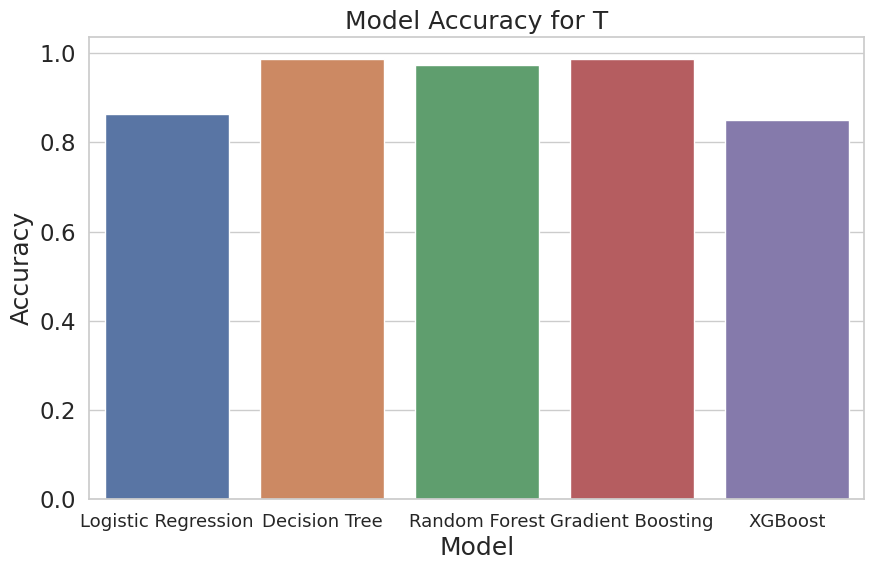

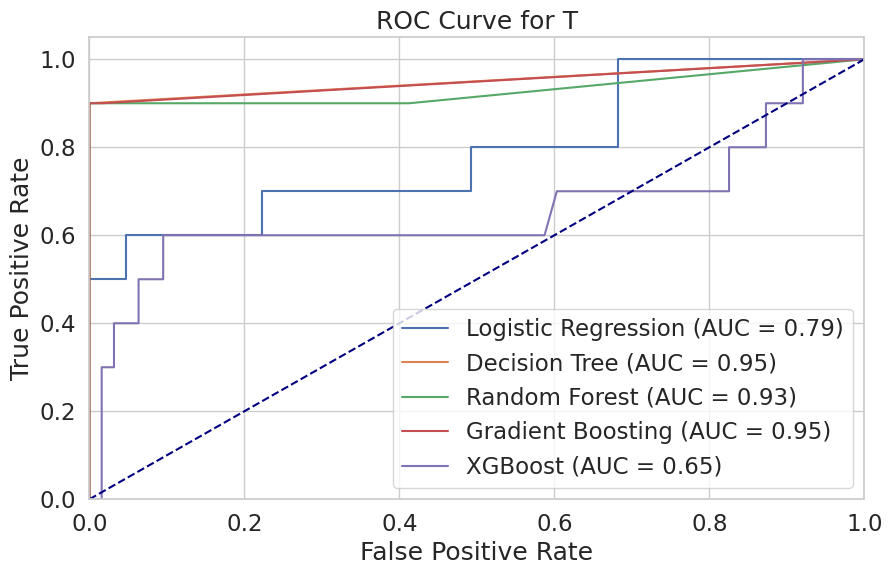

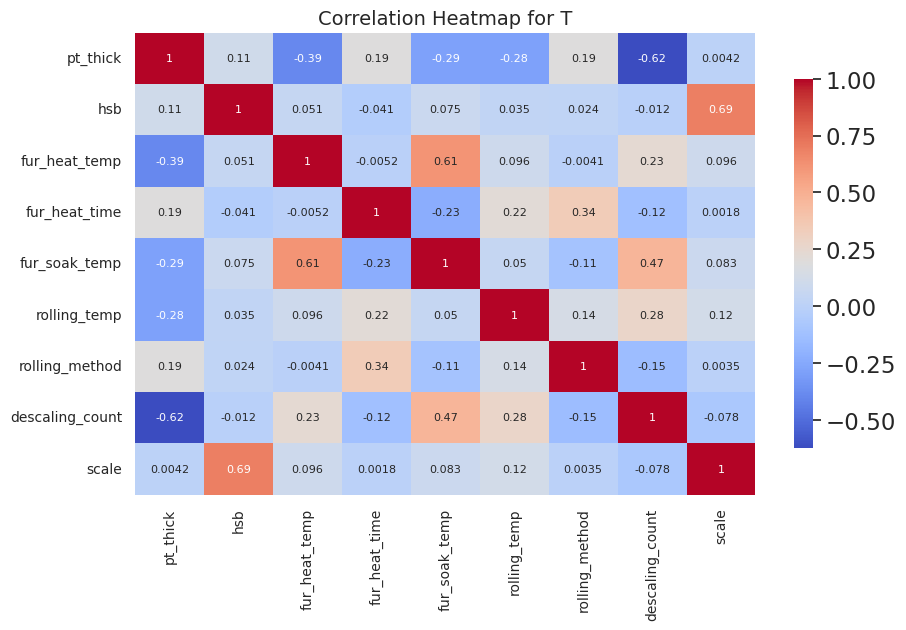

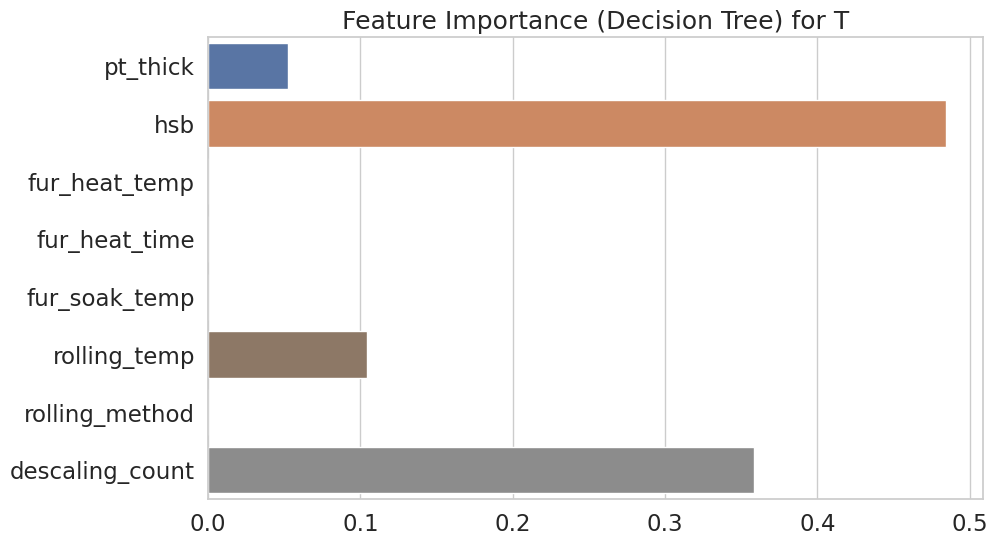

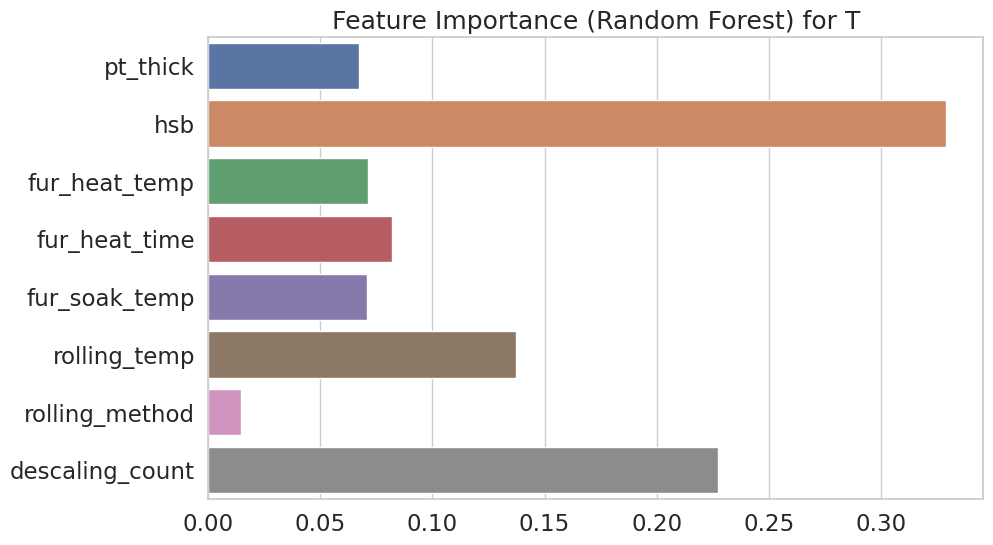

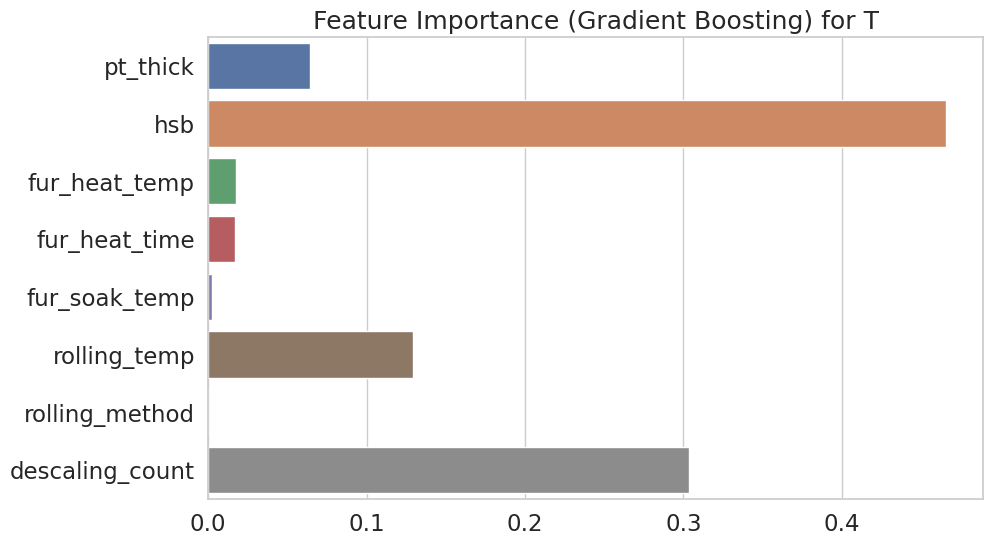

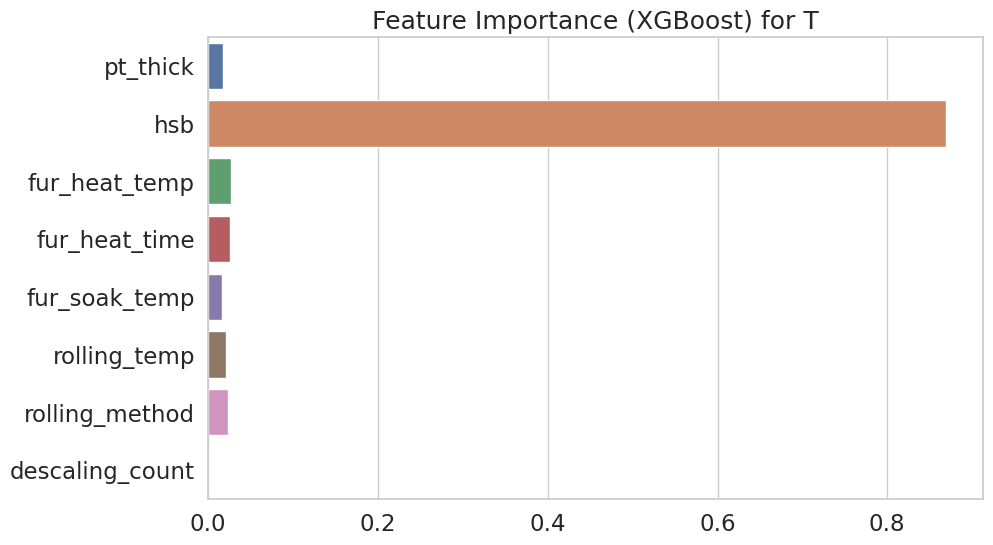

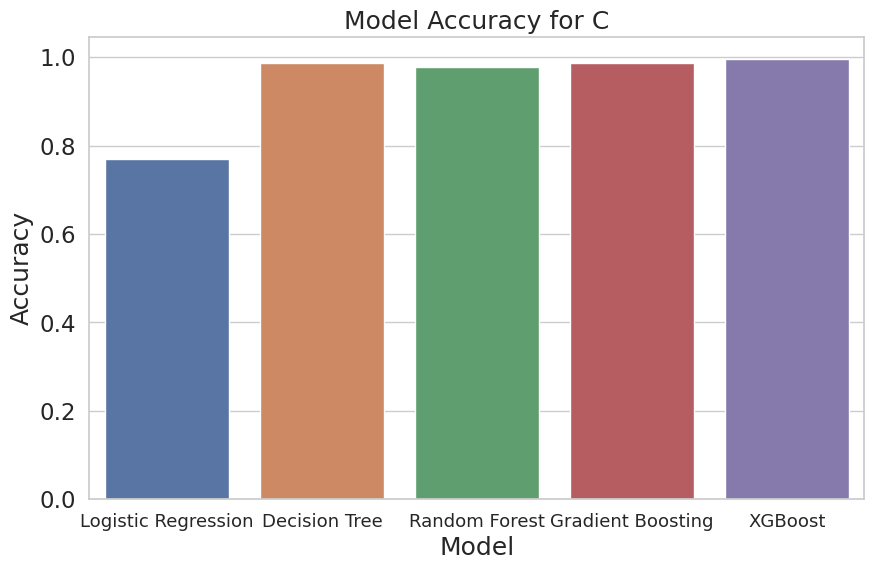

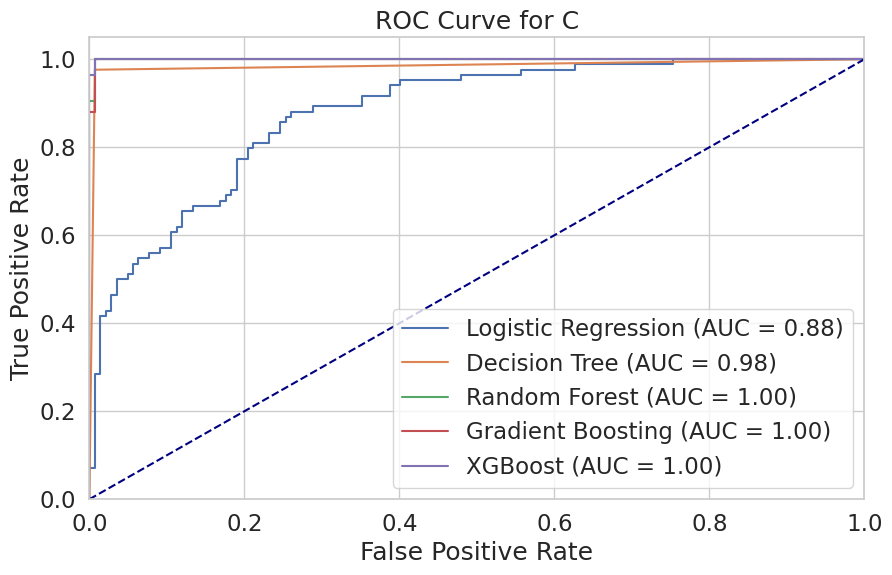

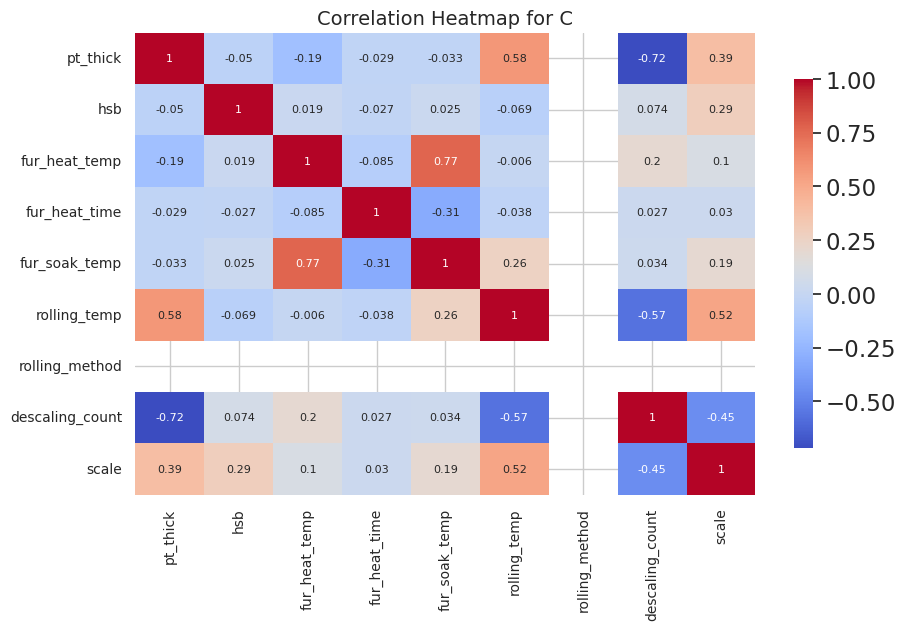

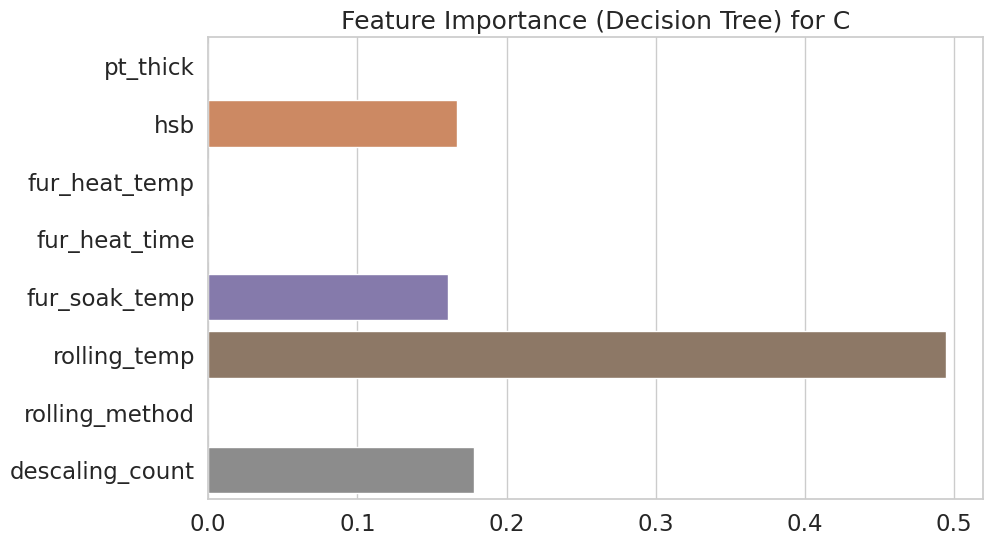

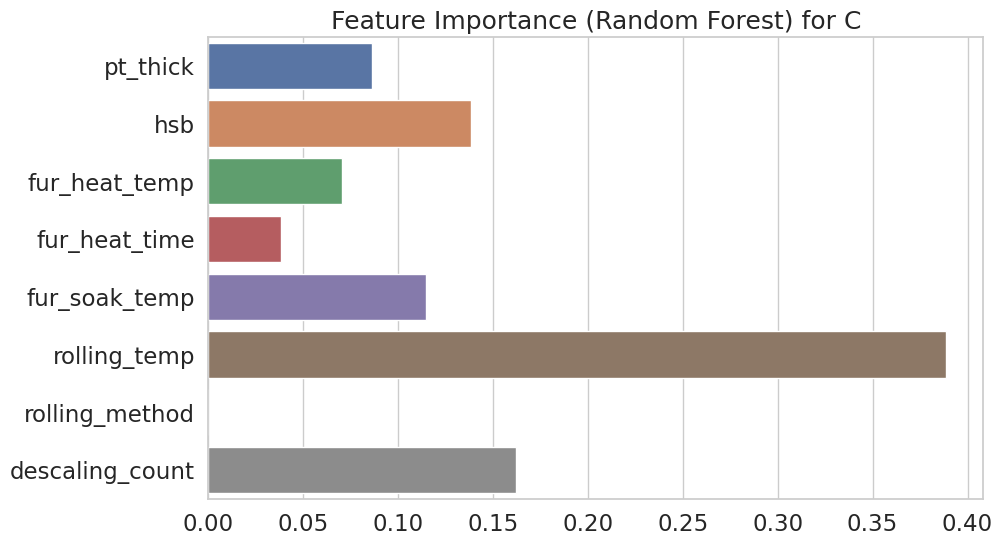

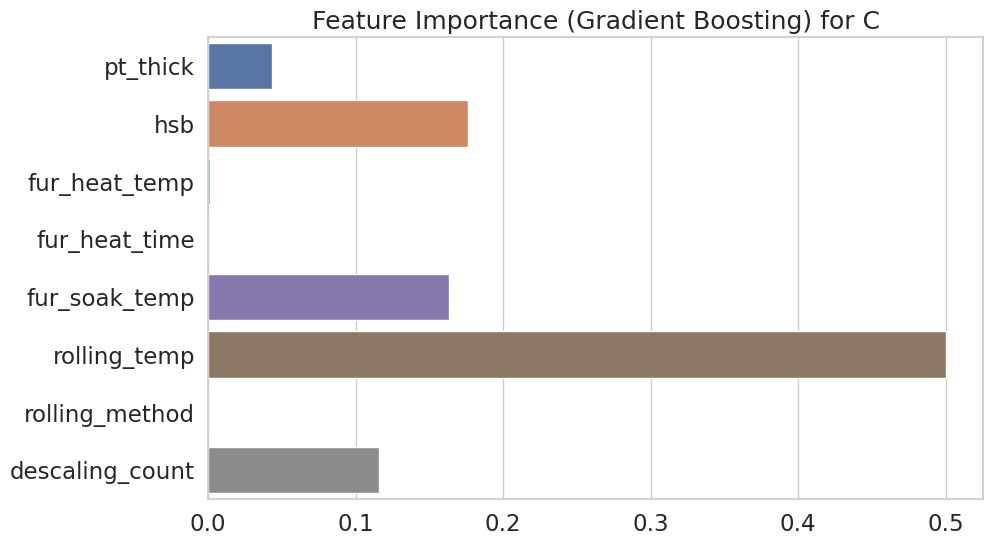

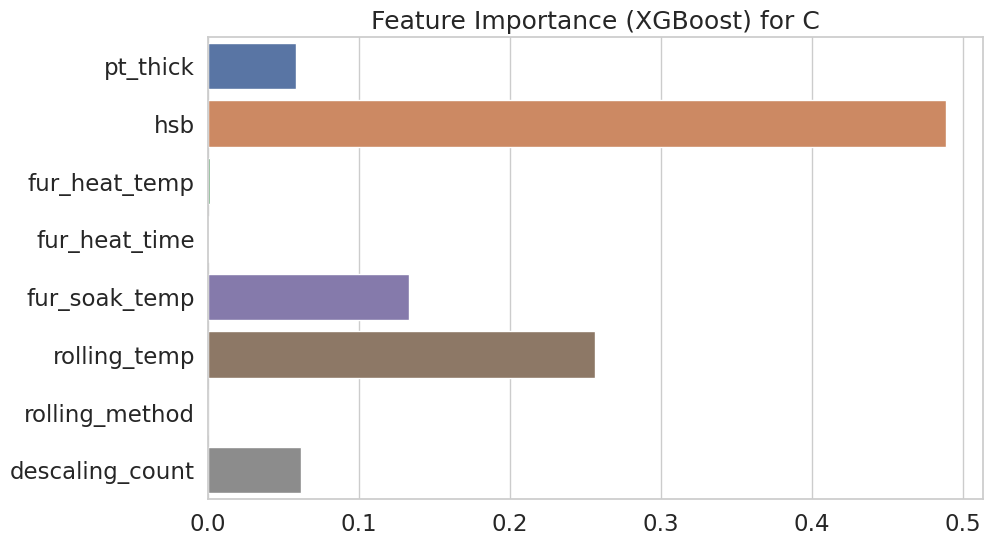

In [25]:
# T 타입에 대한 모델 정확도
plot_model_accuracy(results_df_T, 'T')
plot_roc_curve(models_T, X_T_test, y_T_test, 'T')
plot_correlation_heatmap(df_T, 'T')
plot_feature_importance(feature_importances_T, X_T_test.columns, 'T')

# C 타입에 대한 모델 정확도
plot_model_accuracy(results_df_C, 'C')
plot_roc_curve(models_C, X_C_test, y_C_test, 'C')
plot_correlation_heatmap(df_C, 'C')
plot_feature_importance(feature_importances_C, X_C_test.columns, 'C')

In [26]:
# 